# `CLOUD.jl` - 1D linear advection with dynamic mode decomposition

In [5]:
using CLOUD
using Plots
using OrdinaryDiffEq
plots_path = "../plots/advection_dgmulti_1d_demo/"
results_path = "../results/advection_dgmulti_1d_demo/";

Define the physical problem (advection of a sine wave)

In [8]:
a = 1.0  # advection velocity
A = 1.0  # amplitude
L = 1.0  # domain length
k = 4*π/L  # wave number
T = 1*L/a  # end time
initial_data = InitialDataSine(A,k)
conservation_law = linear_advection_equation(a,λ=1.0)

ConservationLaw{1, 1}(ConstantLinearAdvectionFlux{1}((1.0,)), nothing, ConstantLinearAdvectionNumericalFlux{1}((1.0,), 1.0), nothing)

Set up a quadrature-based DG scheme of degree `p` with `M` elements and periodic boundary conditions

In [10]:
M = 4  # number of elements
p = 3  # degree of discretization
reference_approximation=ReferenceApproximation(
    DGMulti(p), Line())
spatial_discretization = SpatialDiscretization(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    (0.0,L), M), reference_approximation)
results_path = save_project(conservation_law,
     spatial_discretization, initial_data, StrongConservationForm(), 
     (0.0, T), Eager(), results_path, overwrite=true, clear=true);

Run the `OrdinaryDiffEq` solver with RK4, taking `n_s` snapshots

In [11]:
n_s = 10
dt = 0.1*(L/M)/(a*(2*p+1))
ode_problem = semidiscretize(load_project(results_path)...)
save_solution(ode_problem.u0, 0.0, results_path, 0)
sol = solve(ode_problem, RK4(), adaptive=false, 
    dt=dt, save_everystep=false,
    callback=save_callback(results_path, ceil(Int, T/(dt*n_s))))
save_solution(last(sol.u), last(sol.t), results_path, "final");

Visualize the solution and calculate the integral L<sup>2</sup> error norm

L2 error: 0.02228586574787329

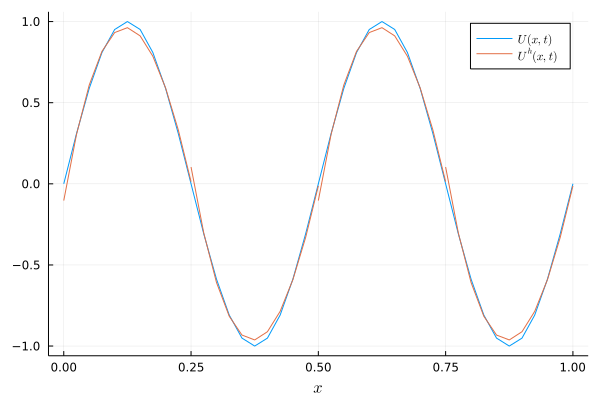

In [12]:
plotter = Plotter(spatial_discretization, plots_path)
error_analysis = ErrorAnalysis(conservation_law, 
    spatial_discretization, 
    results_path)
print("L2 error: ", analyze(error_analysis, last(sol.u), initial_data)[1])
visualize(last(sol.u), plotter, "final.pdf", exact_solution=initial_data,
    label="U^h(x,t)", label_exact="U(x,t)")

Run a dynamic mode decomposition (truncated to `n_m` modes via POD) on snapshot data

In [13]:
n_m = 3
dmd = DMDAnalysis(results_path,rank=2*n_m)
X, Y = load_snapshots(results_path, dmd.time_steps)
σ, λ, ϕ = analyze(dmd, X, Y);

Plot the DMD spectrum

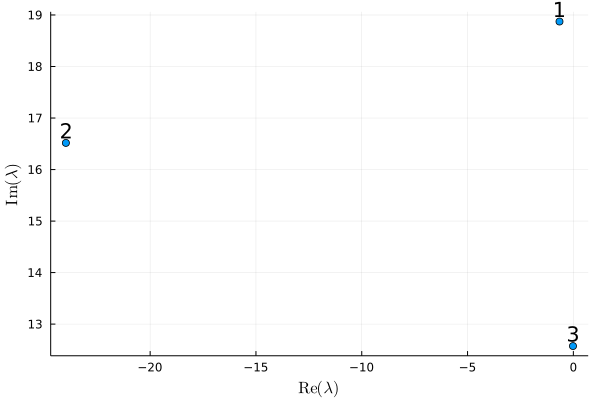

In [14]:
plot_spectrum(dmd, λ[imag(λ) .> 0])

Plot the real part of the first `n_m` DMD modes

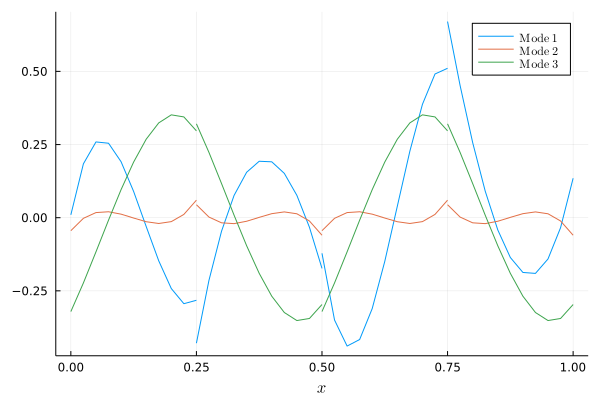

In [16]:
mode_plotter = Plotter(spatial_discretization, dmd.path)
plot_modes(dmd, mode_plotter, real(ϕ[:,imag(λ) .> 0]), 1)